<img src="img/svds_logo.png" alt="SVDS" width="500" align="left">

# PyData San Francisco 2016
## Applied Time Series Econometrics in Python (and R) Tutorial
### Section 3: ARIMAX Models

### Topics in this section include 


  - 3.1 Model Estimation and Identification
  - 3.2 Model Diagnostic Checking
    * Define the stationary and invertible conditions for $ARIMA(p,d,q)$ models
  - 3.3 Model performance evaluation (in-sample fit)
  - 3.4 Forecasting and forecast evaluation 
  - 3.5 A few words on adding explanatory variables, its use cases, and its practical suggestions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

<div class="alert alert-info">

** Read a series stored in a csv file. ** This is the same series we used in *Exercise 2*.
</div>

In [2]:
# Import the csv file containing the series for the analysis
# This is the file we just analyzed in Exercise 2

filename_ts = 'data/series1.csv'
ts_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

n_sample = ts_df.shape[0]

In [3]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
              value
2006-06-01  0.21507
2006-07-01  1.14225
2006-08-01  0.08077
2006-09-01 -0.73952
2006-10-01  0.53552


### 3.1 Model Identification (ARIMA Model Determination)

1. Determine the *degree of differencing*, $d$

2. Study the patterns of the ACF and PACF of the appropriately differenced series: $\omega_t = (1-B)^d z_t$, as these autocorrelation functions will provide indication for the choice of the order of autoregressive and the moving average components.  While we did not have enough time in this tutorial, it is very beneficial to study the *theoretical* ACF and PACF of the autoregressive, moving average, and the mixed autoregressive and moving average processes.

3. The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |

4. In general, the ACF of an autoregressive process is similar to the PACF of a moving average process, and vice versa.
5. Keep in mind that these are theoretical properties. In practice, the estimated sample ACF and PACF can come with large variances, deviating from the underlying theoretical behavior. As such, it is prudent to recognize that these are  but broad characteristics, and it is quite possible that several candidate models are narrowed down and will need to be investigaged further in the later stage of the modeling process.

In [4]:
# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(115,)
(5,)
Training Series: 
 2015-08-01    0.60371
2015-09-01   -1.27372
2015-10-01   -0.93284
2015-11-01    0.08552
2015-12-01    1.20534
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.16411
2016-02-01    0.95226
2016-03-01    0.36485
2016-04-01   -2.26487
2016-05-01   -2.38168
Name: value, dtype: float64


In [5]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

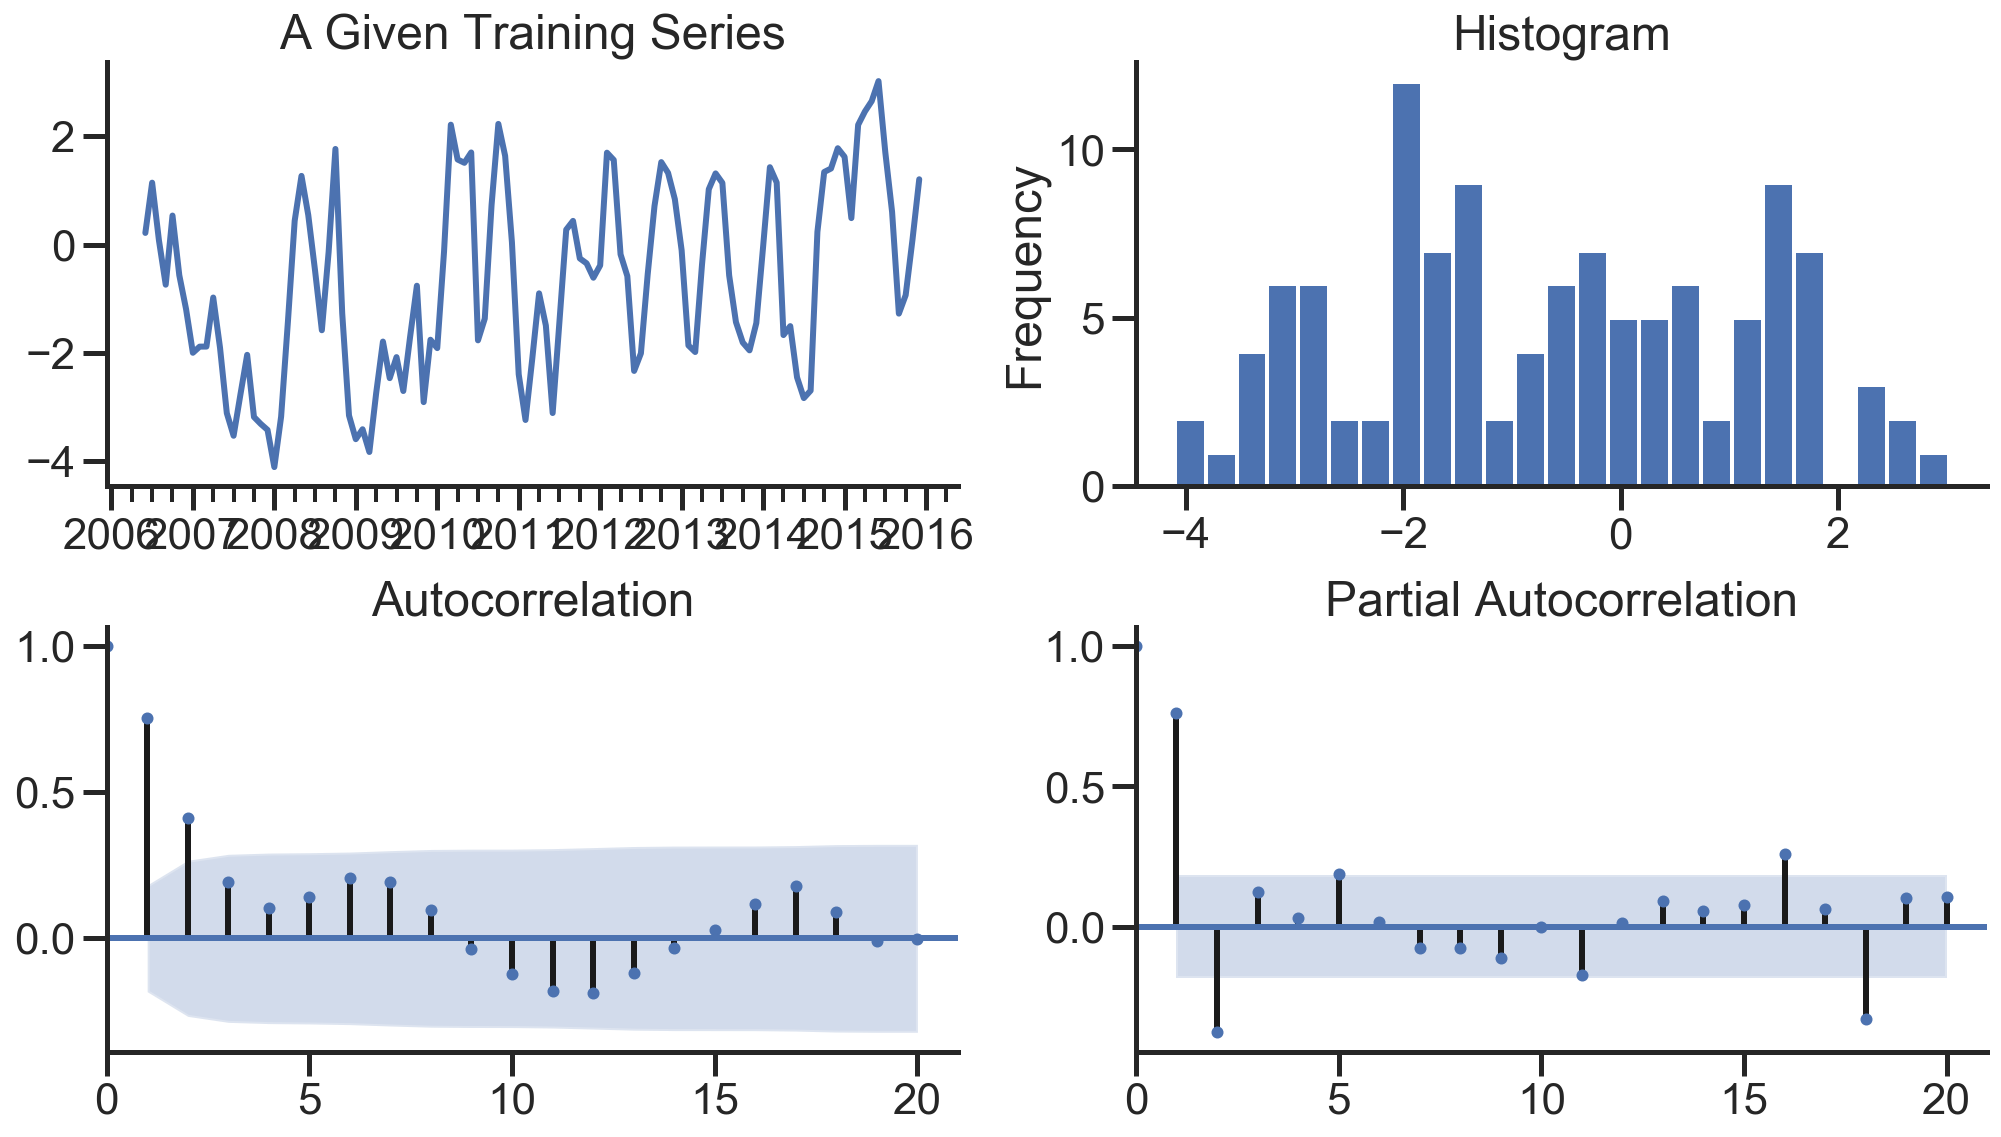

In [6]:
tsplot(ts_train, title='A Given Training Series', lags=20);

** Observations from the sample ACF and sample PACF (based on first 20 lags) **

- The sample autocorrelation gradually tails off.
- The sample partial autocorrelation does not exactly cut off at some lag $p$ but does not exactly tail off either.
- Based on these observations, we could attempt an ARIMA(2,0,0) model as a starting point, although other orders could serve as candidates as well.

In [7]:
# Up until this point in the tutorial, statsmodels 0.6.1 is fine.
# From here on, we need an updated version of statsmodels 0.8.0rc1

In [8]:
# Uncomment to install
# !pip install --pre statsmodels --upgrade

In [9]:
#Model Estimation

# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                  115
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -171.685
Date:                Tue, 24 Mar 2020   AIC                            349.370
Time:                        16:34:29   BIC                            357.605
Sample:                    06-01-2006   HQIC                           352.712
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0609      0.101     10.511      0.000       0.863       1.259
ar.L2         -0.3456      0.094     -3.664      0.000      -0.530      -0.161
sigma2         1.1471      0.153      7.516      0.000       0.848       1.446
===================================================================================
Ljung-Box (Q):                       70.87   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.00   Prob(JB):                         0.50
Heteroskedasticity (H):               0.76   Skew:                            -0.27
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Digression:

* In practice, one could *search* over a few models using the visual clues above as a starting point.  
* The code below gives one such example

In [10]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No fre

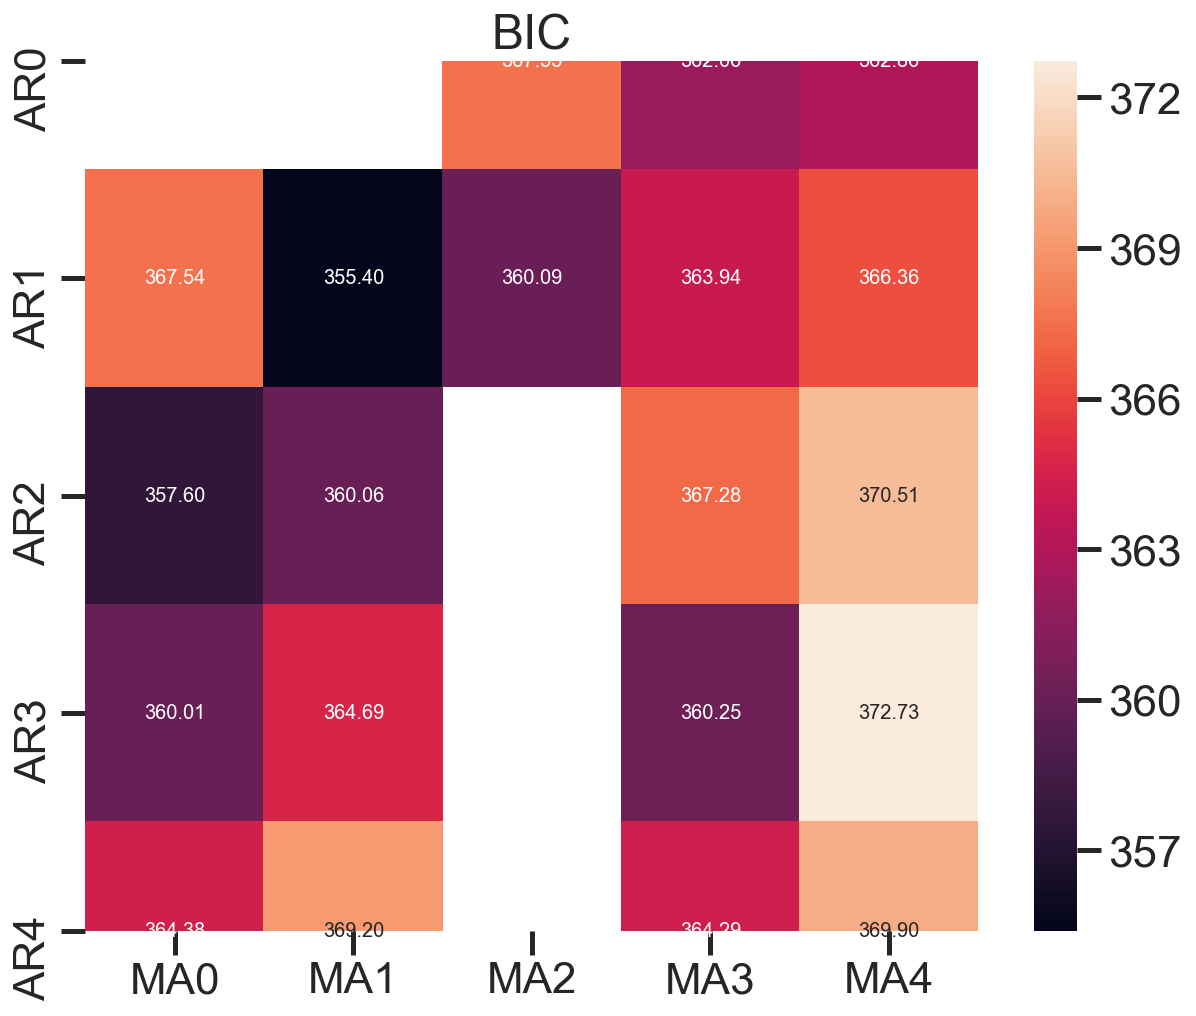

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [12]:
# Alternative model selection method, limited to only searching AR and MA parameters

train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No freq

C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


AIC (4, 2)
BIC (1, 1)


### 3.2 Model Diagnostic Checking

* Conduct visual inspection of the residual plots
* Residuals of a well-specified ARIMA model should mimic *Gaussian white noises*: the residuals should be uncorrelated and distributed approximated normally with mean zero and variance $n^{-1}$
* Apparent patterns in the standardized residuals and the estimated ACF of the residuals give an indication that the model need to be re-specified
* The *results.plot_diagnostics()* function conveniently produce several plots to facilitate the investigation.
* The estimation results also come with some statistical tests

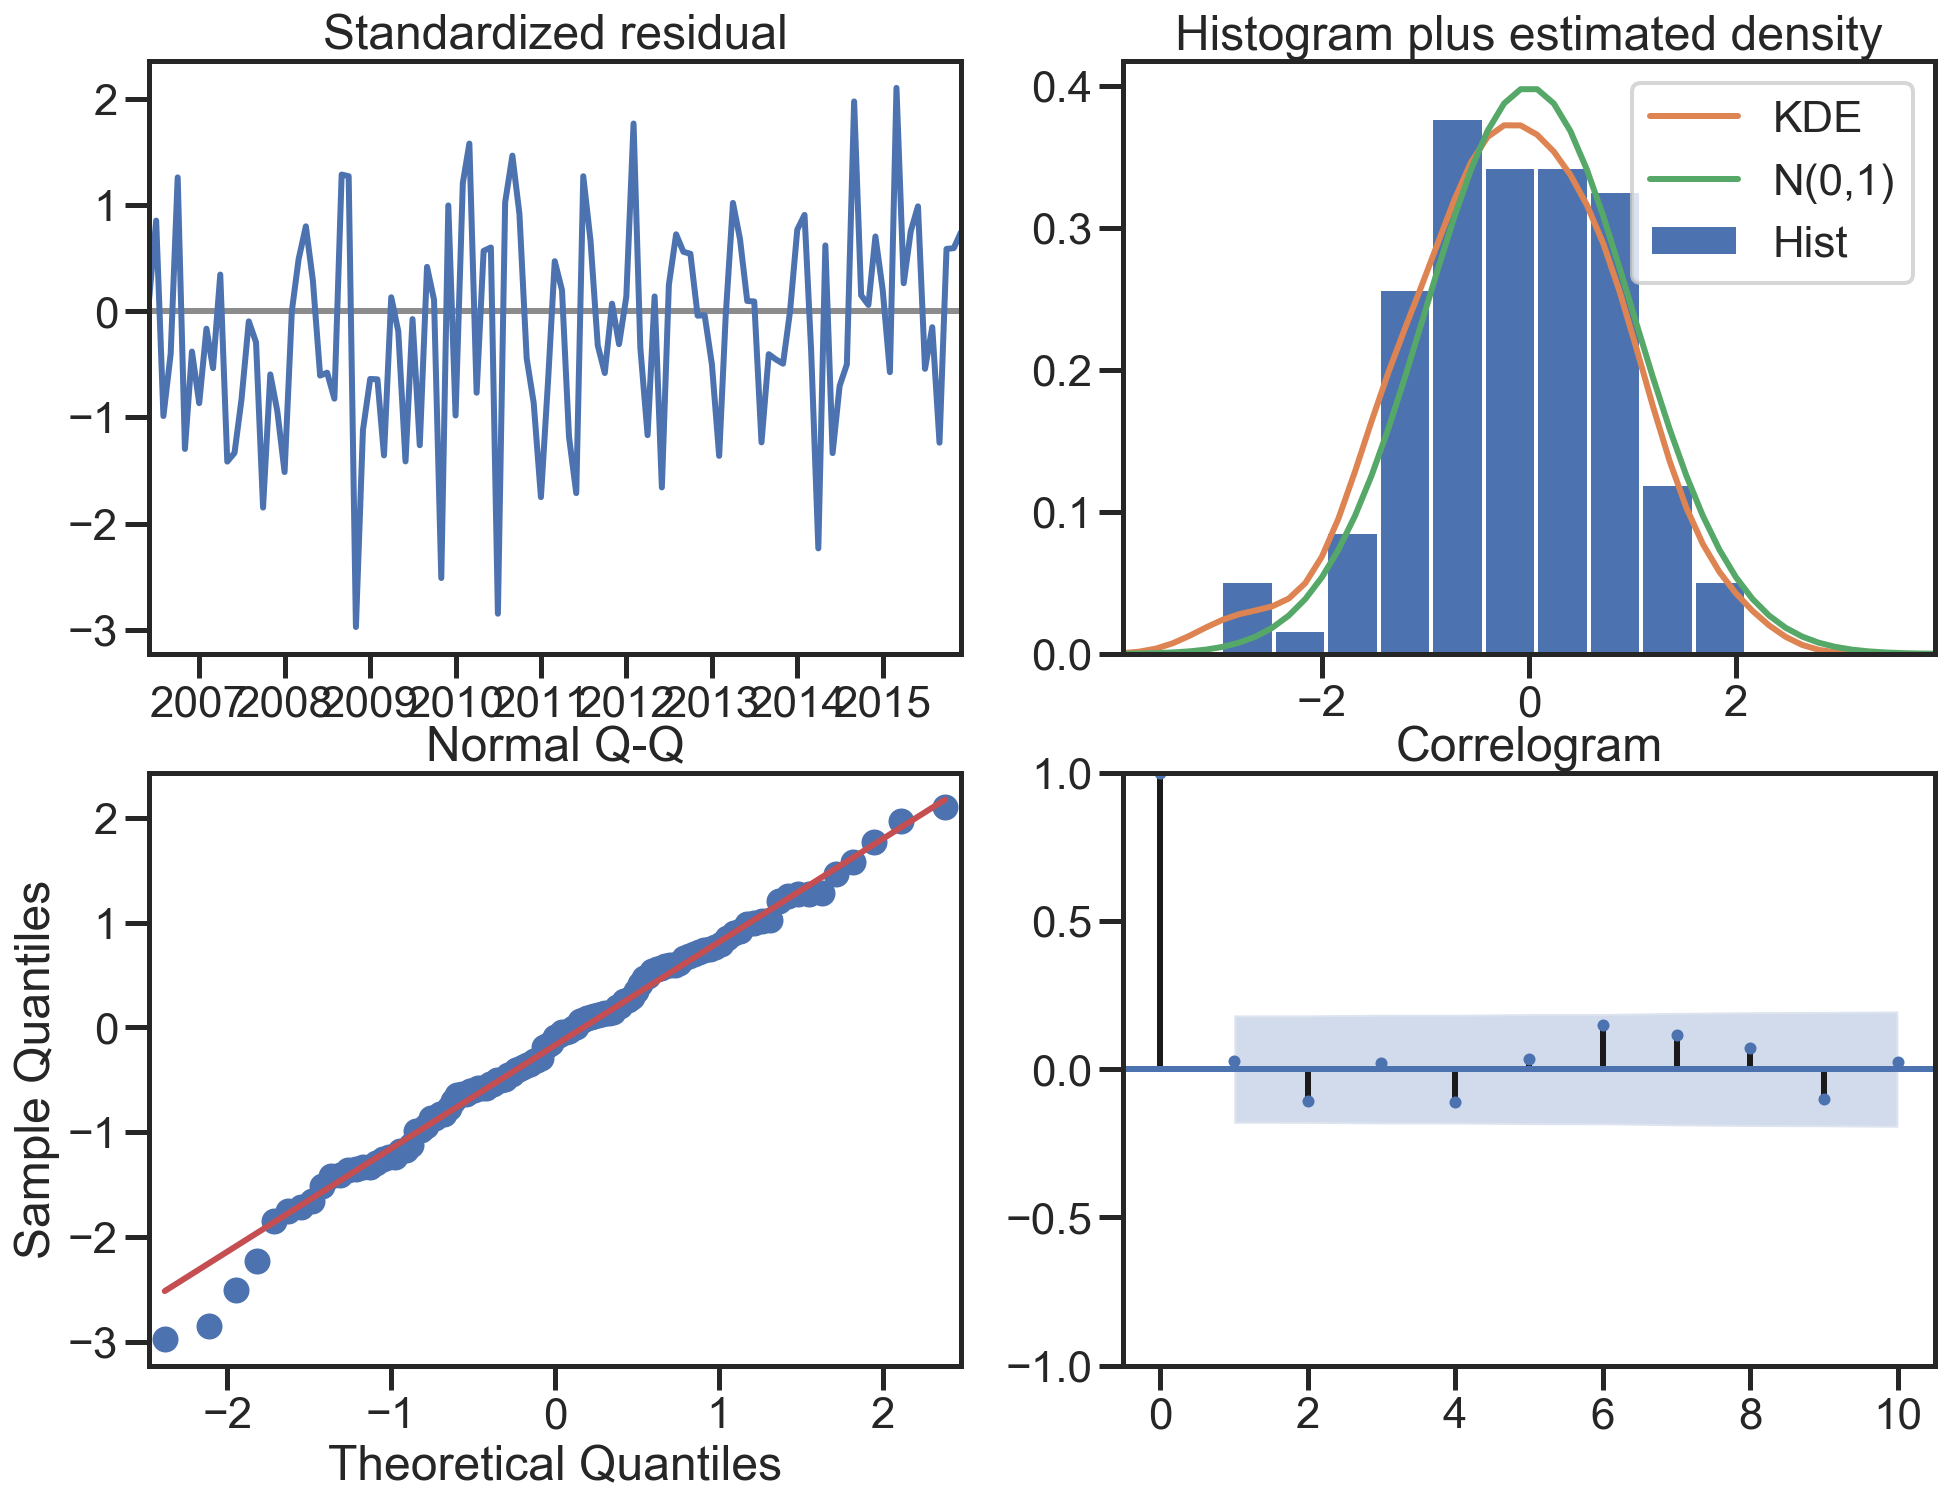

In [13]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals

model_results.plot_diagnostics(figsize=(16, 12));

### 3.2.1 Formal testing

** More information about the statistics under the parameters table, tests of standardized residuals **

#### Test of heteroskedasticity
- http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

#### Test of normality (Jarque-Bera)
- http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

#### Test of serial correlation (Ljung-Box)
- http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation

In [14]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=0.758, p=0.397

Test normality of residuals (jarquebera): stat=1.394, p=0.498

Test serial correlation of residuals (ljungbox): stat=70.871, p=0.002

Durbin-Watson test on residuals: d=1.88
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


### 3.3 Model performance evaluation (in-sample fit)

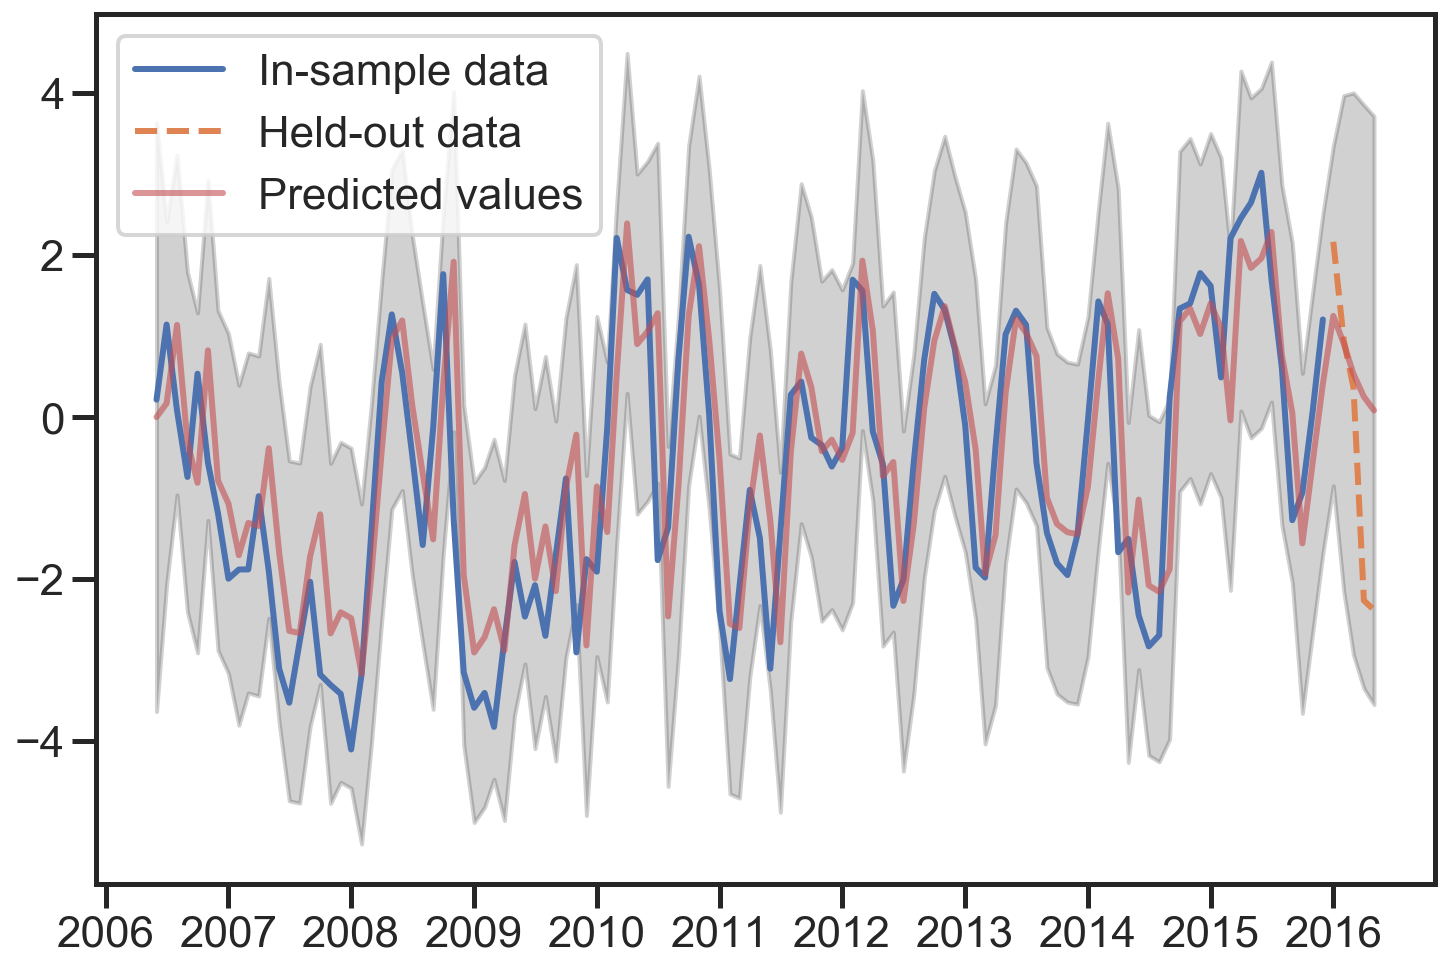

In [15]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [16]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [17]:
rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
print("MASE: ", mase)

RMSE:  1.071636878840765
MAPE:  149.40302582315982
MASE:  0.993487893439543


C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/inde

### 3.4 Forecasting and forecast evaluation

In [18]:
rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print(rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print(mape)

mase = get_mase(ts_test, pred_mean.ix[ts_test.index])
print(mase)

1.6288239951853314
61.45625012198833
0.9410128986266715


C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/inde

### Exericse 3:



In [19]:
# Import the csv file containing the series for the analysis

# Step 1a: Read the data series
filename_ts = 'data/series2.csv'
series2_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

# Step 1b: Create the training and testing series before analyzing the series

n_sample = series2_df.shape[0]

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

series2_train = series2_df.iloc[:n_train]['value']
series2_test  = series2_df.iloc[n_train:]['value']
print(series2_train.shape)
print(series2_test.shape)
print("Training Series:", "\n", series2_train.tail(), "\n")
print("Testing Series:", "\n", series2_test.head())

(238,)
(12,)
Training Series: 
 2017-11-01    1.08165
2017-12-01    0.40939
2018-01-01    2.17708
2018-02-01    2.21133
2018-03-01   -0.39728
Name: value, dtype: float64 

Testing Series: 
 2018-04-01    0.82064
2018-05-01    0.66053
2018-06-01    0.78946
2018-07-01   -0.02444
2018-08-01   -0.39888
Name: value, dtype: float64


In [20]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", series2_train.shape, "\n")
print("First 5 observations of the data series:", "\n", series2_train.head(), "\n")
print("Last 5 observations of the data series:", "\n", series2_train.tail())

Data shape: (238,) 

First 5 observations of the data series: 
 1998-06-01   -0.59883
1998-07-01   -0.80018
1998-08-01    2.29898
1998-09-01    1.15039
1998-10-01   -1.19258
Name: value, dtype: float64 

Last 5 observations of the data series: 
 2017-11-01    1.08165
2017-12-01    0.40939
2018-01-01    2.17708
2018-02-01    2.21133
2018-03-01   -0.39728
Name: value, dtype: float64


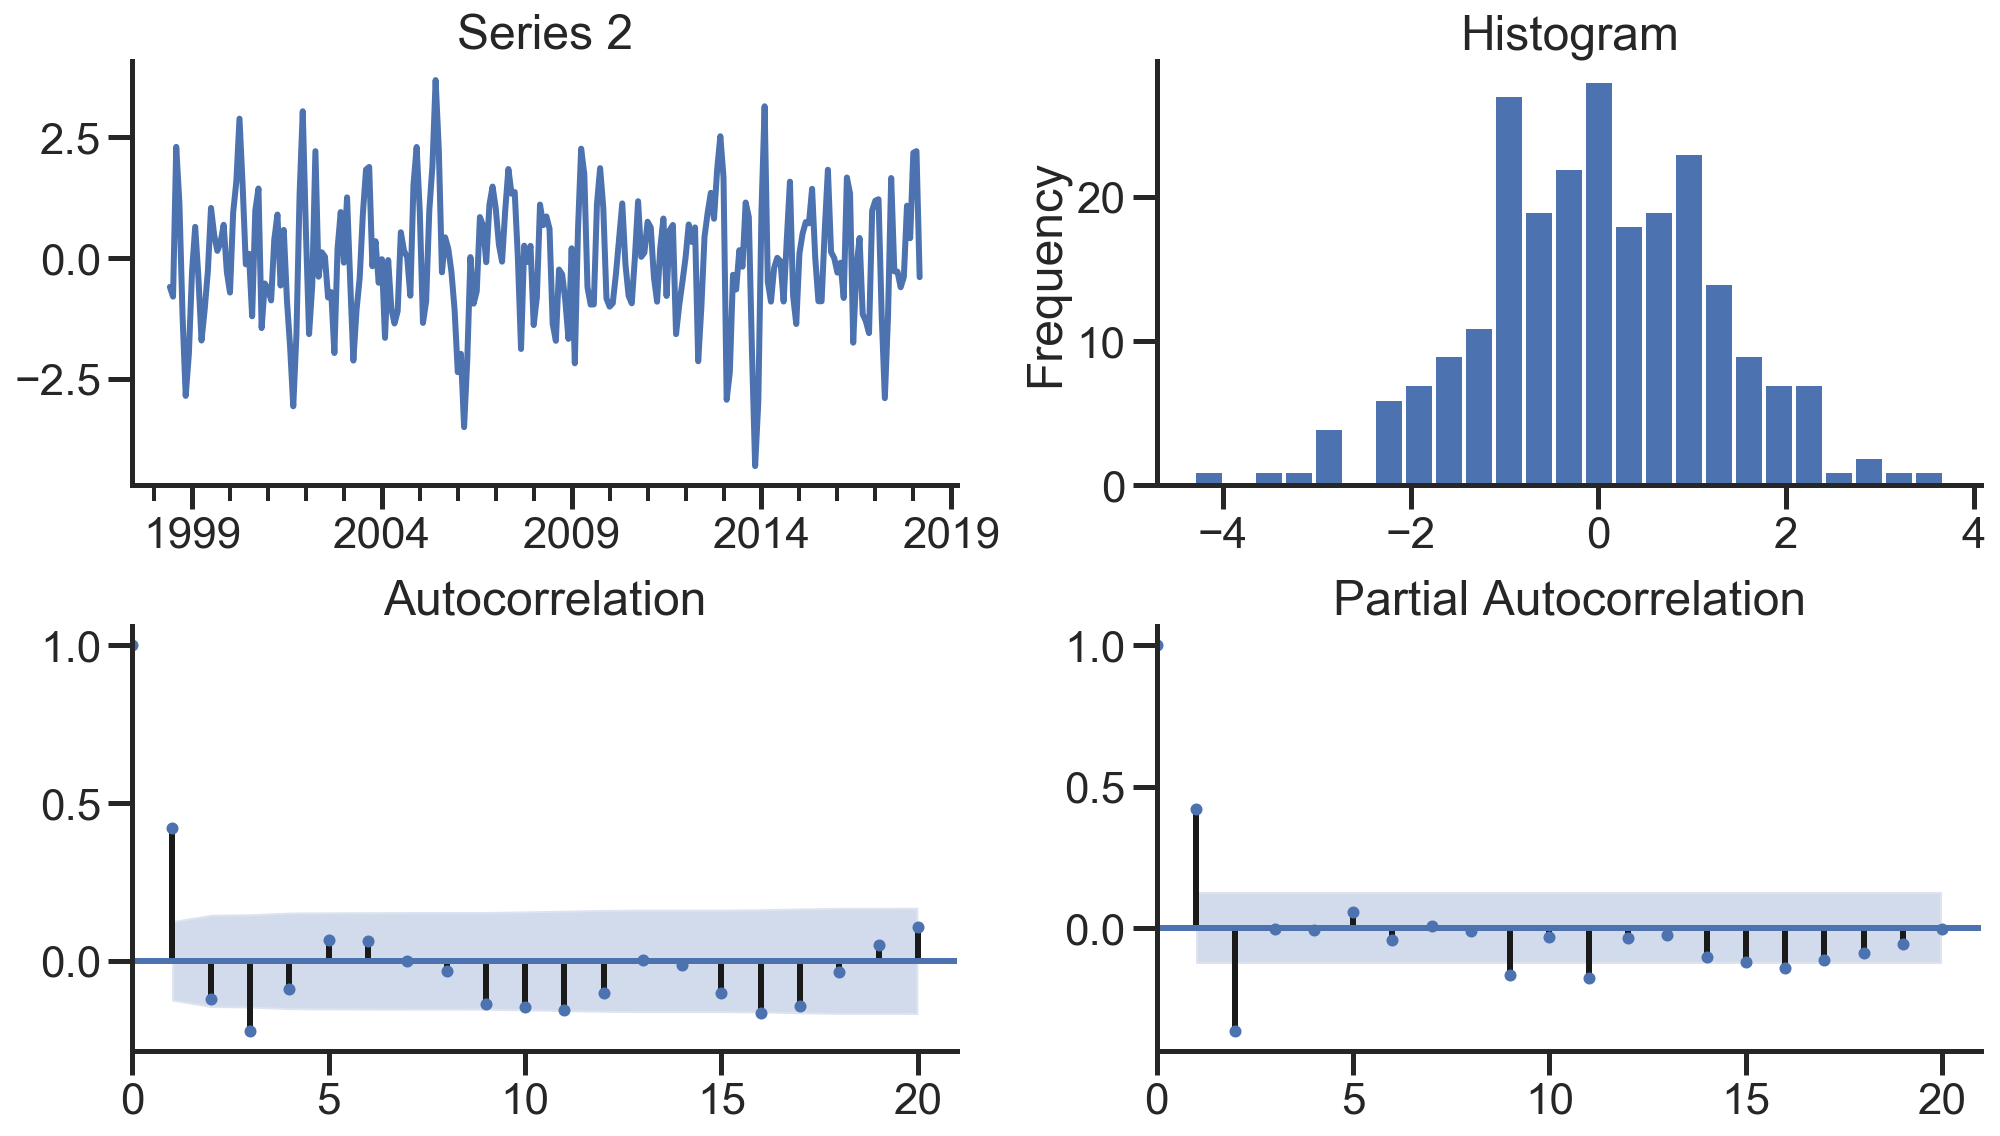

In [23]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
# Choose the number of lags you would like to display. Pick a number that is at least 20.

# tsplot(series2_train, title='Series 2', lags=?);

tsplot(series2_train, title='Series 2', lags=20);

In [ ]:
# Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# and repeat Step 2b


In [29]:
# Step 3: Estimate an non-Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)

# ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(?,?,?))
ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(1,1,1))
ex3_arima_fit = ex3_mod.fit()
print(ex3_arima_fit.summary())

# Discuss your results

C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  238
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -374.127
Date:                Tue, 24 Mar 2020   AIC                            754.254
Time:                        16:36:54   BIC                            764.658
Sample:                    06-01-1998   HQIC                           758.447
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4245      0.071      5.978      0.000       0.285       0.564
ma.L1         -1.0000     33.276     -0.030      0.976     -66.220      64.220
sigma2         1.3499     44.951      0.030      0.9

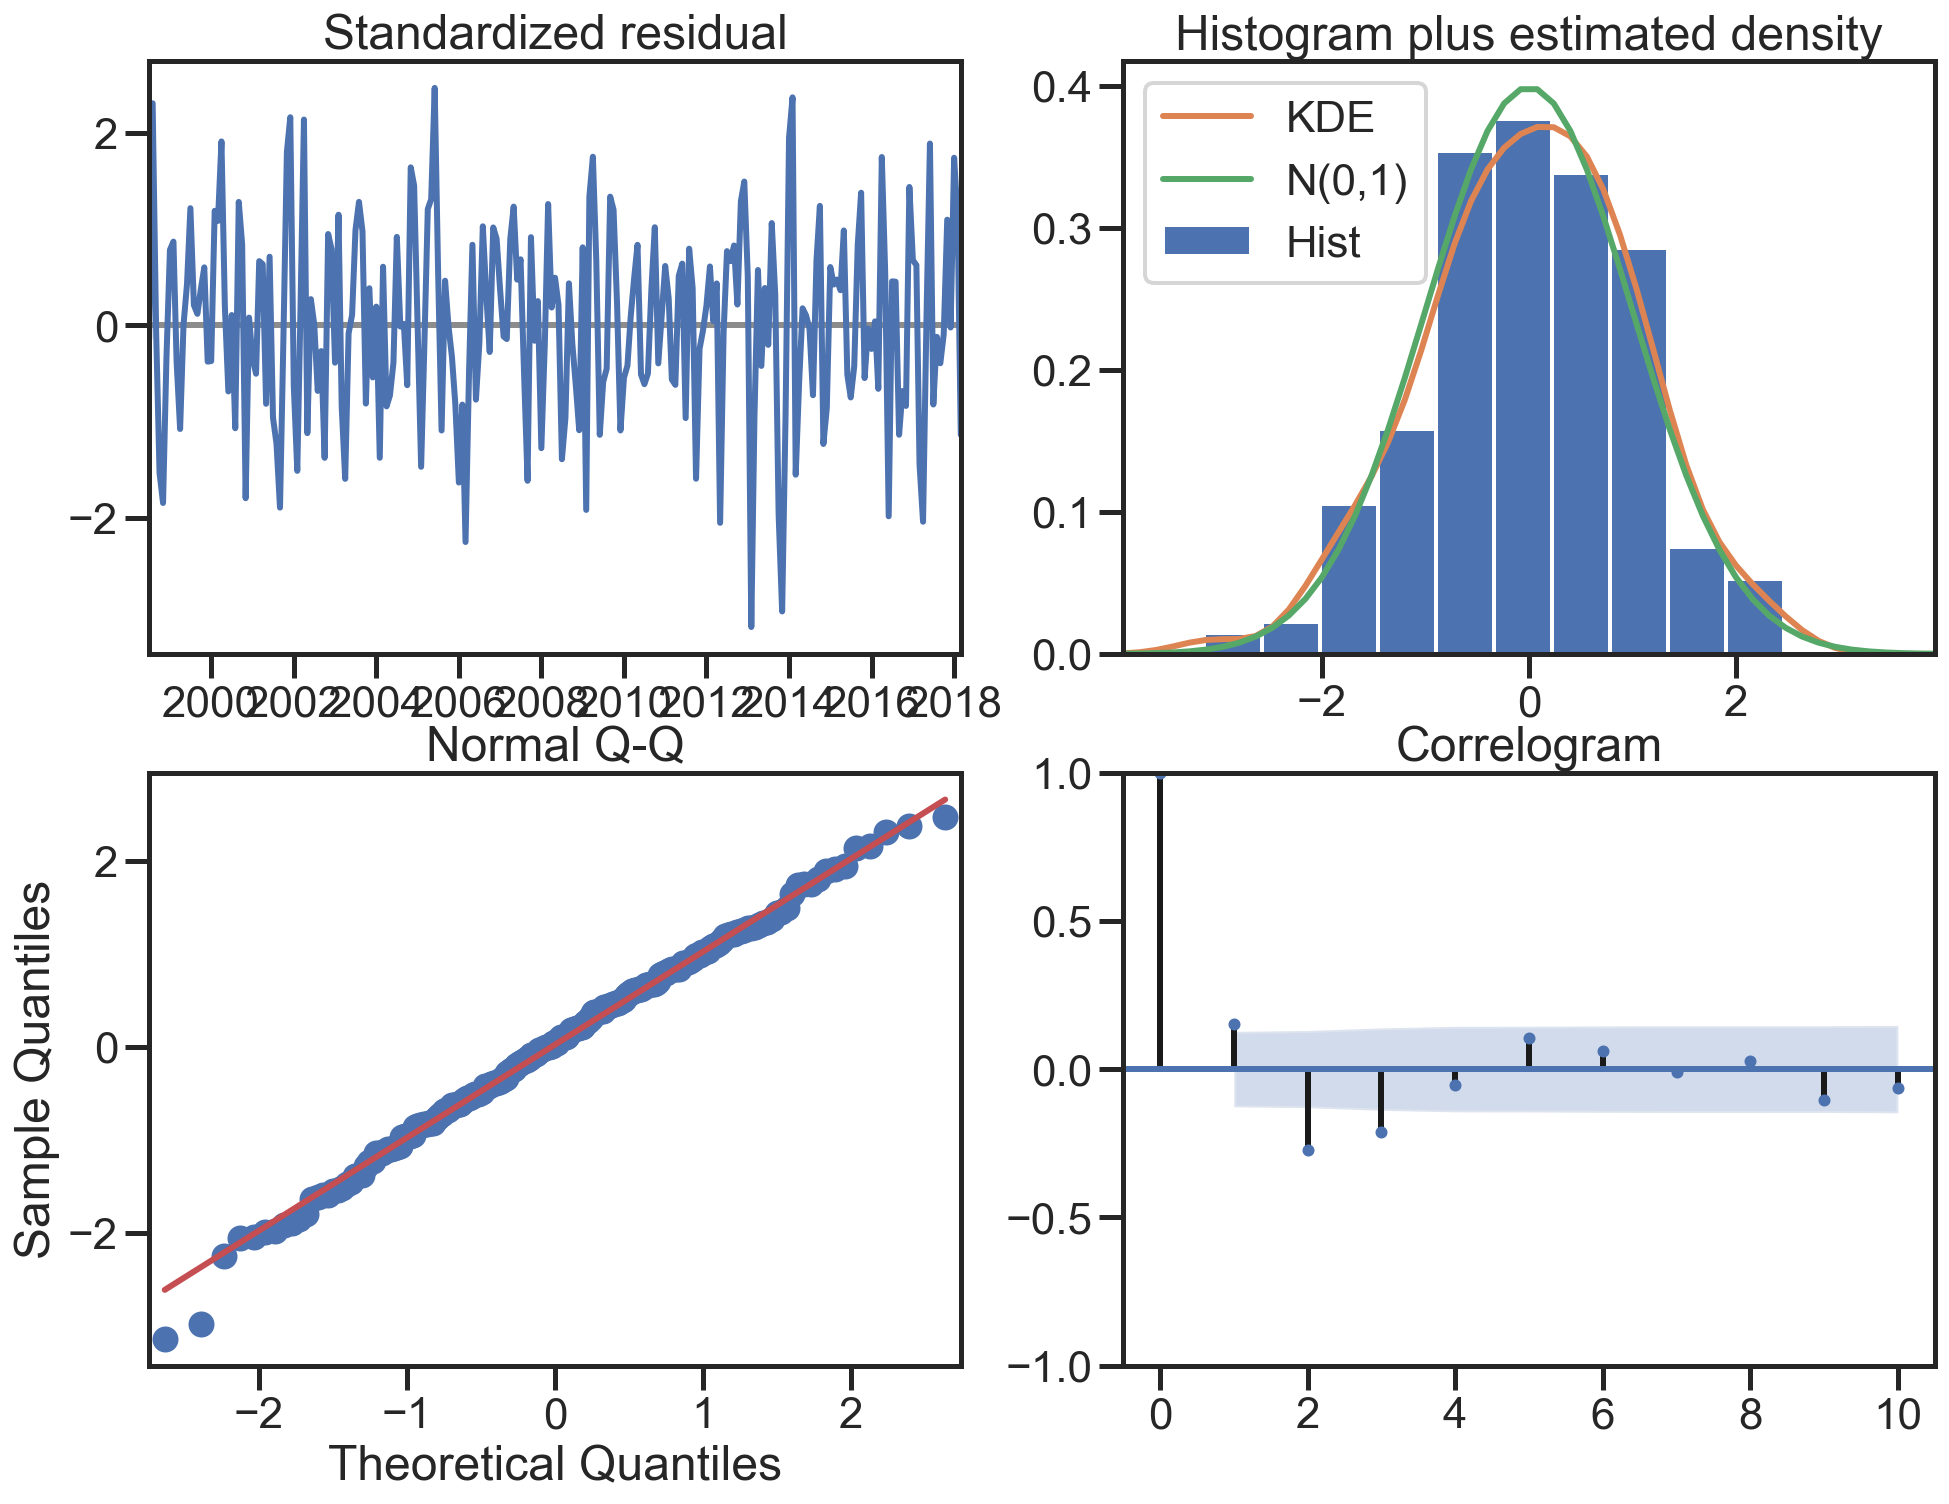

In [30]:
# Step 4: Conduct model diagnostic check

ex3_arima_fit.plot_diagnostics(figsize=(16, 12));

# Discuss these plots

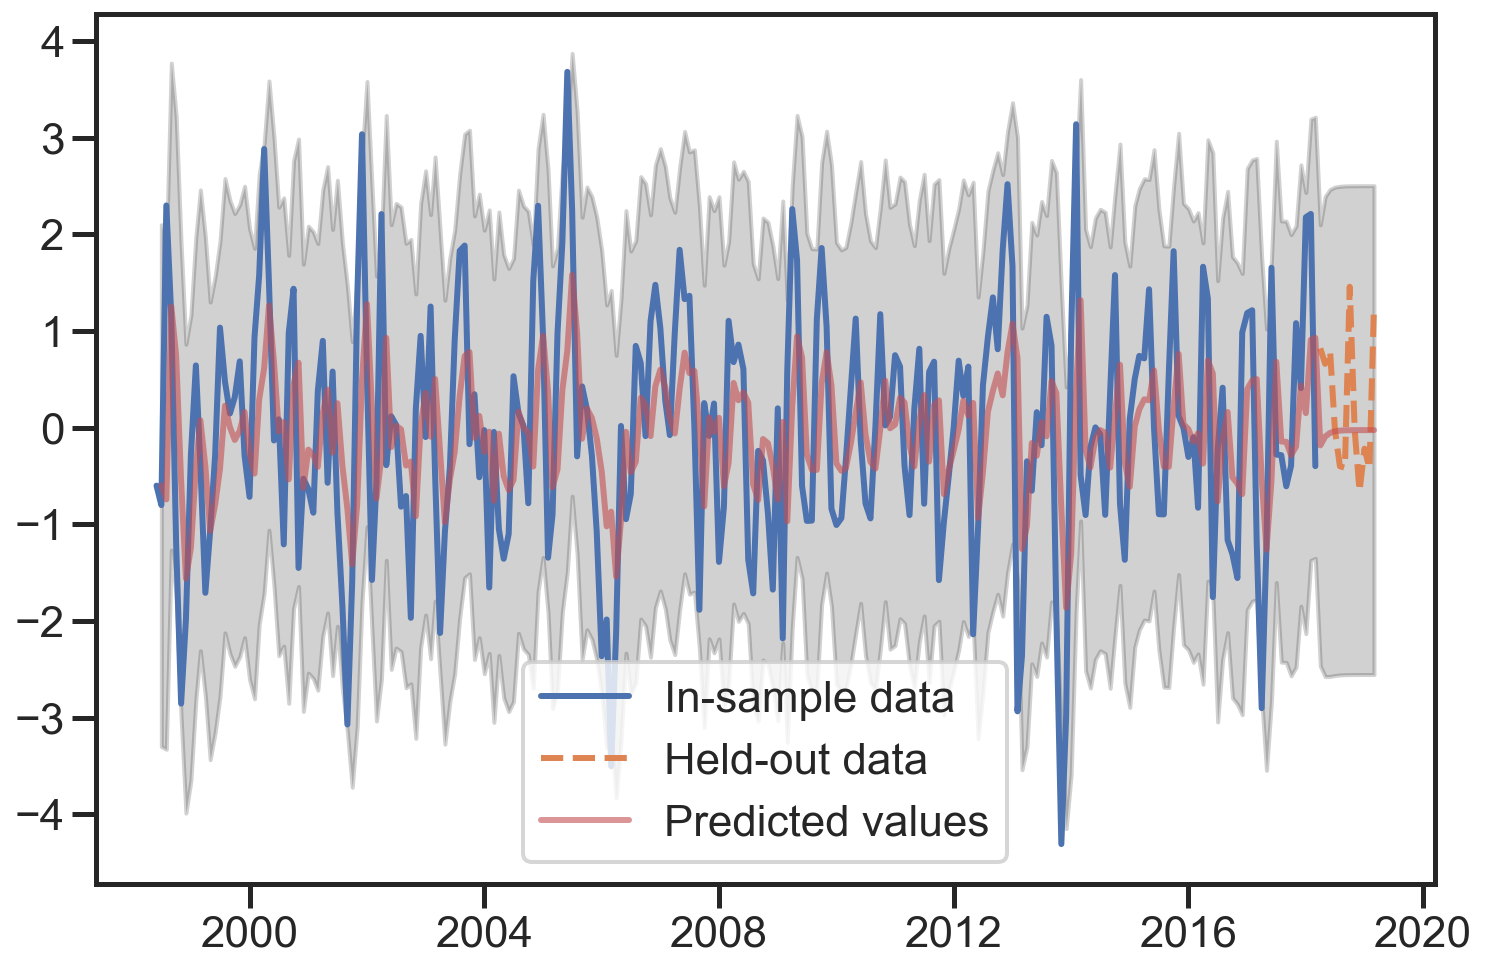

In [31]:
# Step 5: Do a 5-step ahead forecast

# ... codes need to be adjusted

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(series2_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(series2_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = series2_train.index[ex3_arima_fit.loglikelihood_burn]
pred_end = series2_test.index[-1]
pred = ex3_arima_fit.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

## Discuss the results.  How does your forecast look?

In [32]:
rmse = get_rmse(series2_train, pred_mean.ix[ts_test.index])
print(rmse)

mape = get_mape(series2_train, pred_mean.ix[ts_test.index])
print(mape)

mase = get_mase(series2_train, pred_mean.ix[ts_test.index])
print(mase)

1.0226755176392752
81.09216675681608
nan


C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/inde